In [7]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

from feature_importance import process_from_census_data

In [31]:
sa1_data, sa1_tot = process_from_census_data(geo_lev="SA1", normalise=True, boxcox=False, keep_same=True, return_tot=True)
poa_data, poa_tot = process_from_census_data(geo_lev="POA", normalise=True, boxcox=False, keep_same=True, return_tot=True)

In [32]:
poa_data

,Fuel type__Not Applicable,Fuel type__Diesel,Fuel type__Electric,Fuel type__Petrol,Fuel type__LPG/Dual fuel,Fuel type__Other and unknown,NPRD Number of Persons Usually Resident in Dwelling__One person,NPRD Number of Persons Usually Resident in Dwelling__Two persons,NPRD Number of Persons Usually Resident in Dwelling__Three persons,NPRD Number of Persons Usually Resident in Dwelling__Four persons,...,TENLLD Tenure and Landlord Type__Owned with a mortgage,TENLLD Tenure and Landlord Type__Rented: Real estate agent,TENLLD Tenure and Landlord Type__Rented: State or territory housing authority,TENLLD Tenure and Landlord Type__Rented: Community housing provider,TENLLD Tenure and Landlord Type__Rented: Person not in same household,TENLLD Tenure and Landlord Type__Rented: Other landlord type,TENLLD Tenure and Landlord Type__Rented: Landlord type not stated,TENLLD Tenure and Landlord Type__Other tenure type,TENLLD Tenure and Landlord Type__Tenure type not stated,TENLLD Tenure and Landlord Type__Tenure type not applicable
3000,0.026178,0.430491,0.004934,0.534101,0.008388,0.057726,0.301631,0.247388,0.058800,0.019039,...,0.071599,0.422365,0.000929,0.004034,0.047249,0.008329,0.001567,0.013699,0.062369,0.301080
3002,0.021858,0.465919,0.009203,1.161346,0.035088,0.041415,0.297670,0.293069,0.054645,0.029048,...,0.125683,0.311763,0.001150,0.000000,0.057233,0.003739,0.000000,0.012079,0.038251,0.253955
3003,0.038632,0.199692,0.003652,0.564482,0.011724,0.089564,0.289064,0.305785,0.091486,0.042860,...,0.153181,0.417836,0.008841,0.005189,0.051701,0.006150,0.000000,0.010955,0.040938,0.215068
3004,0.021050,0.397259,0.010035,1.159711,0.014564,0.049566,0.314037,0.291519,0.062538,0.027781,...,0.148085,0.346469,0.001224,0.001101,0.039897,0.004039,0.001469,0.011994,0.055195,0.235345
3006,0.010449,0.308610,0.003197,0.633151,0.006852,0.027978,0.291938,0.287370,0.073084,0.023638,...,0.122416,0.416353,0.000228,0.000571,0.042537,0.003597,0.001028,0.012162,0.041395,0.272011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,1.053571,1.750000,0.000000,1.928571,0.160714,0.982143,0.107143,0.357143,0.142857,0.071429,...,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053571,0.232143
3991,0.421801,0.971564,0.000000,1.312796,0.156398,0.753555,0.175355,0.308057,0.075829,0.090047,...,0.241706,0.014218,0.000000,0.000000,0.066351,0.000000,0.000000,0.042654,0.127962,0.208531
3992,0.212171,0.598684,0.000000,1.152961,0.054276,0.376645,0.220395,0.330592,0.118421,0.098684,...,0.376645,0.042763,0.000000,0.000000,0.047697,0.000000,0.000000,0.019737,0.074013,0.118421
3995,0.180996,0.436782,0.002146,1.121992,0.059617,0.236628,0.254866,0.281073,0.096398,0.069119,...,0.203218,0.099770,0.024981,0.007203,0.038621,0.004444,0.001226,0.013793,0.048582,0.203065


In [33]:
drop_col = [x for x in poa_data.columns if "Fuel type" in x]
electric_vals = poa_data["Fuel type__Electric"]
poa_data = poa_data.drop(columns=drop_col)

In [34]:
check = poa_tot * electric_vals
check.sum()

7819.0

Epoch 1/20
1/1 [==============================] - 0s 474ms/step - loss: 0.1944 - mean_absolute_error: 0.1944 - val_loss: 0.5757 - val_mean_absolute_error: 0.5757
Epoch 2/20
1/1 [==============================] - 0s 30ms/step - loss: 0.5595 - mean_absolute_error: 0.5595 - val_loss: 0.3059 - val_mean_absolute_error: 0.3059
Epoch 3/20
1/1 [==============================] - 0s 30ms/step - loss: 0.3085 - mean_absolute_error: 0.3085 - val_loss: 0.1312 - val_mean_absolute_error: 0.1312
Epoch 4/20
1/1 [==============================] - 0s 18ms/step - loss: 0.1244 - mean_absolute_error: 0.1244 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 5/20
1/1 [==============================] - 0s 33ms/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0430 - val_mean_absolute_error: 0.0430
Epoch 6/20
1/1 [==============================] - 0s 33ms/step - loss: 0.0385 - mean_absolute_error: 0.0385 - val_loss: 0.0514 - val_mean_absolute_error: 0.0514
Epoch 7/20
1/1 [=================

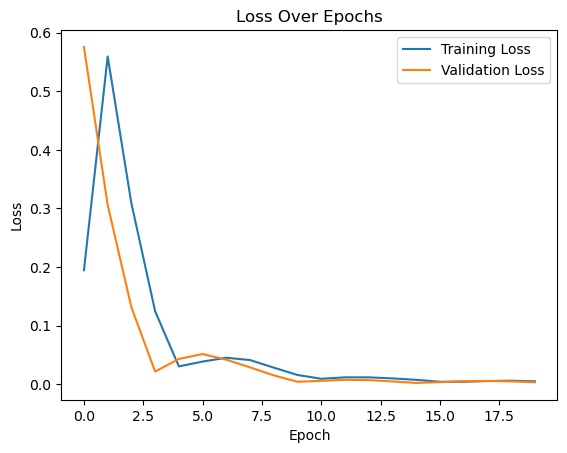

In [35]:
# Create a CNN model
cnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(66,)),
    Dropout(0.3),  # Add dropout layer with dropout rate of 0.3
    Dense(132, activation='relu'),
    Dropout(0.3),  # Add dropout layer with dropout rate of 0.3
    Dense(1)
])

X_train = poa_data
y_train = electric_vals

# Compile the model with the specified optimizer and loss function
optimizer = Adam(learning_rate=0.01)
cnn_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Reshape your data to add a channel dimension
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)

# Train the model
history = cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=X_train.shape[0], validation_split=0.4)

# Visualize the loss history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()


In [36]:
def TRS(initial_weights, know_tot=None):
    # Desired total constraint
    desired_total = know_tot if know_tot else sum(initial_weights)

    # Step 1: Truncate the weights to integers
    truncated_weights = np.floor(initial_weights).astype(int)

    # Step 2: Calculate the discrepancy
    total_truncated = np.sum(truncated_weights)
    discrepancy = desired_total - total_truncated

    # Step 3: Replicate individuals to match the constraint
    if discrepancy > 0:
        # Calculate fractional parts
        fractional_parts = initial_weights - truncated_weights
        
        # Replicate individuals in proportion to their fractional parts
        replication_probs = fractional_parts / np.sum(fractional_parts)
        num_replications = np.random.multinomial(int(discrepancy), replication_probs)
        truncated_weights += num_replications

    # Step 4: Sample individuals if there is an excess
    if discrepancy < 0:
        excess_indices = np.where(truncated_weights > 0)[0]
        excess_weights = truncated_weights[excess_indices]
        
        # Calculate sampling probabilities based on truncated weights
        sampling_probs = excess_weights / np.sum(excess_weights)
        
        # Randomly sample individuals to reduce excess
        num_samples = np.random.multinomial(abs(discrepancy), sampling_probs)
        truncated_weights[excess_indices] -= num_samples

    # Step 5: Your final truncated and rounded integer weights
    return truncated_weights

In [37]:
cnn_model.save("cnn_20.keras")

In [38]:
predicted = cnn_model.predict(sa1_data)
predicted = predicted.flatten()
sa1_data["pred_num_EV_percen"] = predicted
sa1_data["pred_num_EV_percen"]

484/484 [==============================] - 0s 916us/step


20101100101    0.003368
20101100102    0.003313
20101100105    0.003313
20101100106    0.003377
20101100107    0.003313
                 ...   
21704148034    0.003413
21704148035    0.003313
29797979991    0.014472
29797979992    0.014472
29797979993    0.014472
Name: pred_num_EV_percen, Length: 15481, dtype: float32

In [40]:
predicted_num = sa1_data["pred_num_EV_percen"] * sa1_tot

predicted_num = predicted_num.fillna(0) #na value because that sa1 has no one
predicted_rounded = TRS(predicted_num, know_tot=check.sum())

print(predicted_num.sum(), predicted_rounded.sum(), check.sum())

sa1_data["pred_num_EV"] = predicted_rounded

9899.301355244243 7819 7819.0
[False]


In [78]:
ls_of_3000_sa1 = pd.read_csv("data/VIC3000_sa1.csv")
pred_ev_sa1 = pd.read_csv("output/EV_pred/results_EV_pred.csv")
ls_sa1 = ls_of_3000_sa1["SA1_CODE21"]
pred_ev_sa1 = pred_ev_sa1[pred_ev_sa1["SA1"].isin(ls_sa1)]
pred_ev_sa1

,hhsize,dwelltype,hhinc,totalvehs,owndwell,hhid,EV_pred,SA1
215697,4.0,Separate House,2700.0,3.0,Being Purchased,215622,-0.001145,20604111738
215698,4.0,Separate House,1974.0,2.0,Fully Owned,215623,-0.001275,20604111738
215699,4.0,Flat or Apartment,1400.0,1.0,Being Rented,215624,0.005310,20604111738
215700,4.0,Separate House,1200.0,3.0,Fully Owned,215625,0.031688,20604111738
215701,4.0,Separate House,900.0,4.0,Being Purchased,215626,-0.018587,20604111738
...,...,...,...,...,...,...,...,...
262812,1.0,Other,2500.0,0.0,Fully Owned,262737,0.015806,20604150622
262813,1.0,Separate House,1375.0,1.0,Being Rented,262738,-0.010883,20604150622
262814,1.0,Terrace/Townhouse,2600.0,0.0,Occupied Rent-Free,262739,-0.016413,20604150622
262815,1.0,Flat or Apartment,350.0,1.0,Fully Owned,262740,-0.003910,20604150622


In [80]:
ls_EV = sa1_data[sa1_data.index.astype("str").isin(ls_sa1.astype("str"))]["pred_num_EV"]
ls_EV.sum()
# post code 3000 has 170 EV, very wrong

117

In [81]:
final_vals_threshold = {
    "sa1": [],
    "thres": []
}
for sa1 in ls_sa1:
    check_df = pred_ev_sa1[pred_ev_sa1["SA1"]== sa1]
    if len(check_df) == 0:
        continue
    sa1_num_ev = ls_EV[ls_EV.index.astype("str") == str(sa1)].iloc[0]
    if sa1_num_ev == 0:
        continue
    else:
        sa1_num_ev -= 1
    check_df = check_df.sort_values("EV_pred", ascending=False)
    ls_EV_val_percen = check_df["EV_pred"]
    the_threshold = ls_EV_val_percen.iat[sa1_num_ev]
    final_vals_threshold["sa1"].append(sa1)
    final_vals_threshold["thres"].append(the_threshold)

In [82]:
thres_check_3000 =  pd.DataFrame(final_vals_threshold)
thres_check_3000

,sa1,thres
0,20604150529,0.058599
1,20604150527,0.054562
2,20604150524,0.076130
3,20604150522,0.058404
4,20604150521,0.059426
...,...,...
59,20604150307,0.058599
60,20604150306,0.053119
61,20604150305,0.081267
62,20604150301,0.058360


In [83]:
thres_check_3000["thres"].mean()

0.07604650932730828

In [84]:
thres_check_3000["thres"].mode()

0    0.058599
Name: thres, dtype: float64

In [85]:
thres_check_3000["thres"].min()

0.0442666468527368

In [86]:
thres_check_3000["thres"].max()

0.2873587879936881